Imports

In [ ]:
from nb201 import NB201Benchmark
import numpy as np
from warmstart.utils_templates import FullTemplate
import ConfigSpace as CS
from ConfigSpace import Configuration
import ollama
import torchvision
import ast
from llambo.llambo import LLAMBO
from utils import convert_LLAMBO_df_to_synetune_dict
from utils import convert_synetune_dict_to_LLAMBO_df
import openai
from openai import OpenAI

from syne_tune.experiments.benchmark_definitions.nas201 import nas201_benchmark
from syne_tune.blackbox_repository import BlackboxRepositoryBackend
from syne_tune.backend.simulator_backend.simulator_callback import SimulatorCallback
from syne_tune import Tuner, StoppingCriterion

from typing import Optional, Dict, Any, List, Union
import logging
from syne_tune.optimizer.schedulers import FIFOScheduler
from syne_tune.optimizer.schedulers.searchers import StochasticAndFilterDuplicatesSearcher


Load NB201 Benchmark

In [ ]:
b = NB201Benchmark(path="./nb201.pkl", dataset='cifar10')
cs = b.get_configuration_space()
config = cs.sample_configuration()  # samples a configuration uniformly at random

print(cs)
print("Numpy representation: ", config.get_array())
print("Dict representation: ", config.get_dictionary())

#configuration from a dict
new_config = Configuration(cs, values=config.get_dictionary())
print(new_config)

y, cost = b.objective_function(config)
print("Test error: %f %%" % y)
print("Runtime %f s" % cost)

Arguments for LLAMBO

In [ ]:
task_context = {
    'model': 'CNN',
    'task': 'classification',
    'tot_feats': 32 * 32 * 3,
    'cat_feats': 0,
    'num_feat': 32 * 32 * 3,
    'n_classes': 10,
    'metric': 'loss',
    'lower_is_better': True,
    'num_samples': 50000,
    'hyperparameter_constraints': {
        'op_0_to_1': ['categorical', None, ["none", "skip_connect", "avg_pool_3x3", "nor_conv_1x1", "nor_conv_3x3"]],
        # [type, transform, [min_value, max_value]]
        'op_0_to_2': ['categorical', None, ["none", "skip_connect", "avg_pool_3x3", "nor_conv_1x1", "nor_conv_3x3"]],
        'op_0_to_3': ['categorical', None, ["none", "skip_connect", "avg_pool_3x3", "nor_conv_1x1", "nor_conv_3x3"]],
        'op_1_to_2': ['categorical', None, ["none", "skip_connect", "avg_pool_3x3", "nor_conv_1x1", "nor_conv_3x3"]],
        'op_1_to_3': ['categorical', None, ["none", "skip_connect", "avg_pool_3x3", "nor_conv_1x1", "nor_conv_3x3"]],
        'op_2_to_3': ['categorical', None, ["none", "skip_connect", "avg_pool_3x3", "nor_conv_1x1", "nor_conv_3x3"]]
    }
}


def eval_point(config):
    new_config = Configuration(b.get_configuration_space(), values=config)
    res = b.objective_function(new_config)
    res_dict = {
        "score": res[0],
        "train_time": res[1]
    }
    return config, res_dict

Ollama

In [ ]:
# chat_engine = "llama3"
# model = ollama.pull(chat_engine)
# response = ollama.chat(model="llama3", messages=[{'role': 'user', 'content': 'Why is the sky blue?'}])
# print(response)
# ollama.list()

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)


def fetch_statistics(dict, dataset):
    images = dataset.data
    labels = dataset.targets

    images_np = np.array(images)
    labels_np = np.array(labels)

    pixel_mean = np.mean(images_np / 255.)
    pixel_std = np.std(images_np / 255.)

    class_counts = np.bincount(labels_np)
    class_distribution = class_counts / len(labels_np)

    dict['pixel_mean'] = pixel_mean
    dict['pixel_std'] = pixel_std
    dict['class_distribution'] = class_distribution.tolist()

    return dict


task_context = fetch_statistics(task_context, trainset)

Warmstart

In [ ]:
context = "No_Context"


def extract_configs_from_response(response):
    content = response.choices[0].message.content
    start = content.find("[")
    end = content.rfind("]") + 1
    list_str = content[start:end]
    configurations = ast.literal_eval(list_str)
    return configurations


def is_dict_valid_in_config_space(d, config_space):
    try:
        # Attempt to create a Configuration object with the given dictionary and config space
        config = CS.Configuration(config_space, values=d)
        return True
    except:
        # Return False if the dictionary is not valid
        return False
    # Function to check if all dictionaries in a list are valid in the given configuration space


def check_all_list(parsed_dicts, config_space):
    for idx, d in enumerate(parsed_dicts):
        if not is_dict_valid_in_config_space(d, config_space):
            return False
    return True


def obtain_all_list_valid(resp, config_space):
    if check_all_list(resp, config_space):
        return resp
    print("fail")


def generate_init_conf(n_samples, client):
    template_object = FullTemplate(context=context, provide_ranges=True)
    user_message = template_object.add_context(config_space=cs, num_recommendation=n_samples, task_dict=task_context)
    messages = []
    messages.append({"role": "system", "content": "You are an AI assistant that helps people find information."})
    messages.append({"role": "user", "content": user_message})

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        temperature=0.7,
        max_tokens=4000,
        top_p=0.95,
        n=max(5, 3),  # e.g. for 5 templates, get 2 generations per template
        timeout=100
    )
    configs = extract_configs_from_response(response)
    return obtain_all_list_valid(configs, cs)

#print(generate_init_conf(3))

Random sampling of initial points

In [ ]:
def generate_random_samples(n_samples):
    configs = []
    for n in range(n_samples):
        config = cs.sample_configuration().get_dictionary()
        configs.append(config)

    key_mapping = {
        'op_0_to_1': 'hp_x0',
        'op_0_to_2': 'hp_x1',
        'op_0_to_3': 'hp_x2',
        'op_1_to_2': 'hp_x3',
        'op_1_to_3': 'hp_x4',
        'op_2_to_3': 'hp_x5'
    }

    synetune_configs = []
    for item in configs:
        new_item = {key_mapping[old_key]: value for old_key, value in item.items()}
        synetune_configs.append(new_item)

    return synetune_configs

Llambo

In [ ]:
client = OpenAI(
    organization='org-HIWwqsnxyBU3xMl6PkwdjxdN',
    project='proj_g30ZlMFGBNu4qsUctIhNI5B3',
    api_key='sk-proj-cTiFSkfqsowfmg6FId0iT3BlbkFJfDi43ms9k13R9bKElYE1'
)

llambo = LLAMBO(task_context, sm_mode='discriminative', n_candidates=10, n_templates=2, n_gens=10,
                alpha=0.1, n_initial_samples=5, n_trials=4,
                init_f=generate_init_conf,
                bbox_eval_f=eval_point,
                chat_engine="gpt-4o-mini",
                client=client)
llambo.seed = 0

# run optimization
#configs, fvals = llambo.optimize(test_metric="score")

Searcher

In [ ]:
logger = logging.getLogger(__name__)

MAX_RETRIES = 100


class TestSearcher(StochasticAndFilterDuplicatesSearcher):

    def __init__(
            self,
            config_space: Dict[str, Any],
            metric: Union[List[str], str],
            points_to_evaluate: Optional[List[dict]] = None,
            **kwargs,
    ):
        super().__init__(
            config_space,
            metric=metric,
            points_to_evaluate=points_to_evaluate,
            **kwargs,
        )

    def configure_scheduler(self, scheduler):
        assert isinstance(
            scheduler, FIFOScheduler
        ), "This searcher requires FIFOScheduler scheduler"
        super().configure_scheduler(scheduler)

    def get_state(self) -> Dict[str, Any]:
        return dict(
            super().get_state(),
        )

    def _restore_from_state(self, state: Dict[str, Any]):
        super()._restore_from_state(state)

    def get_config(self, **kwargs) -> Optional[Dict[str, Any]]:
        config = self._next_initial_config()
        if config is not None:
            return config
        config = llambo.get_config()
        return convert_LLAMBO_df_to_synetune_dict(config)

    def _update(self, trial_id: str, config: Dict[str, Any], result: Dict[str, Any]):
        llambo._update_observations(convert_synetune_dict_to_LLAMBO_df(config), result)


Simple searcher combined with LLAMBO

In [ ]:
logging.getLogger().setLevel(logging.WARNING)

random_seed = 1
nb201_random_seed = 0
n_workers = 1
dataset_name = "cifar10"
benchmark = nas201_benchmark(dataset_name)

max_resource_attr = benchmark.max_resource_attr
trial_backend = BlackboxRepositoryBackend(
    blackbox_name=benchmark.blackbox_name,
    elapsed_time_attr=benchmark.elapsed_time_attr,
    max_resource_attr=max_resource_attr,
    dataset=dataset_name,
    seed=nb201_random_seed,
)

blackbox = trial_backend.blackbox
nas_configuration_space = blackbox.configuration_space_with_max_resource_attr(
    max_resource_attr
)

In [ ]:
for i in range(5):
    llambo = LLAMBO(task_context, sm_mode='discriminative', n_candidates=10, n_templates=2, n_gens=10,
                    alpha=0.1, n_initial_samples=5, n_trials=4,
                    init_f=generate_init_conf,
                    bbox_eval_f=eval_point,
                    chat_engine="gpt-4o-mini",
                    client=client)
    llambo.seed = i

    points_to_evaluate = llambo.initialize_configs(5)
    points_to_evaluate = convert_LLAMBO_df_to_synetune_dict(points_to_evaluate)
    scheduler = FIFOScheduler(
        config_space=nas_configuration_space,
        max_resource_attr=max_resource_attr,
        mode=benchmark.mode,
        metric=benchmark.metric,
        random_seed=random_seed,
        searcher=TestSearcher(config_space=nas_configuration_space, metric=benchmark.metric,
                              points_to_evaluate=points_to_evaluate, random_seed=random_seed)
    )

    max_num_trials_started = 5
    stop_criterion = StoppingCriterion(max_num_trials_started=max_num_trials_started)
    print_update_interval = 700
    results_update_interval = 300
    tuner = Tuner(
        trial_backend=trial_backend,
        scheduler=scheduler,
        stop_criterion=stop_criterion,
        n_workers=n_workers,
        sleep_time=0,
        tuner_name="llambo-with-warmstart-trial-" + str(i),
        results_update_interval=results_update_interval,
        print_update_interval=print_update_interval,
        callbacks=[SimulatorCallback()],
        metadata={
            "seed": random_seed,
            "algorithm": "LLAMBO",
            "tag": "NAS",
            "benchmark": "nas201-" + dataset_name

        }
    )

    tuner.run()

random initial points

In [ ]:
for i in range(5):
    llambo = LLAMBO(task_context, sm_mode='discriminative', n_candidates=10, n_templates=2, n_gens=10,
                    alpha=0.1, n_initial_samples=5, n_trials=4,
                    init_f=generate_init_conf,
                    bbox_eval_f=eval_point,
                    chat_engine="gpt-4o-mini",
                    client=client)
    llambo.seed = i + 5

    points_to_evaluate = generate_random_samples(5)

    scheduler = FIFOScheduler(
        config_space=nas_configuration_space,
        max_resource_attr=max_resource_attr,
        mode=benchmark.mode,
        metric=benchmark.metric,
        random_seed=random_seed,
        searcher=TestSearcher(config_space=nas_configuration_space, metric=benchmark.metric,
                              points_to_evaluate=points_to_evaluate, random_seed=random_seed)
    )

    max_num_trials_started = 5
    stop_criterion = StoppingCriterion(max_num_trials_started=max_num_trials_started)
    print_update_interval = 700
    results_update_interval = 300
    tuner = Tuner(
        trial_backend=trial_backend,
        scheduler=scheduler,
        stop_criterion=stop_criterion,
        n_workers=n_workers,
        sleep_time=0,
        tuner_name="random-points-trial-" + str(i),
        results_update_interval=results_update_interval,
        print_update_interval=print_update_interval,
        callbacks=[SimulatorCallback()],
        metadata={
            "seed": random_seed,
            "algorithm": "random",
            "tag": "NAS",
            "benchmark": "nas201-" + dataset_name

        }
    )

    tuner.run()

Plots

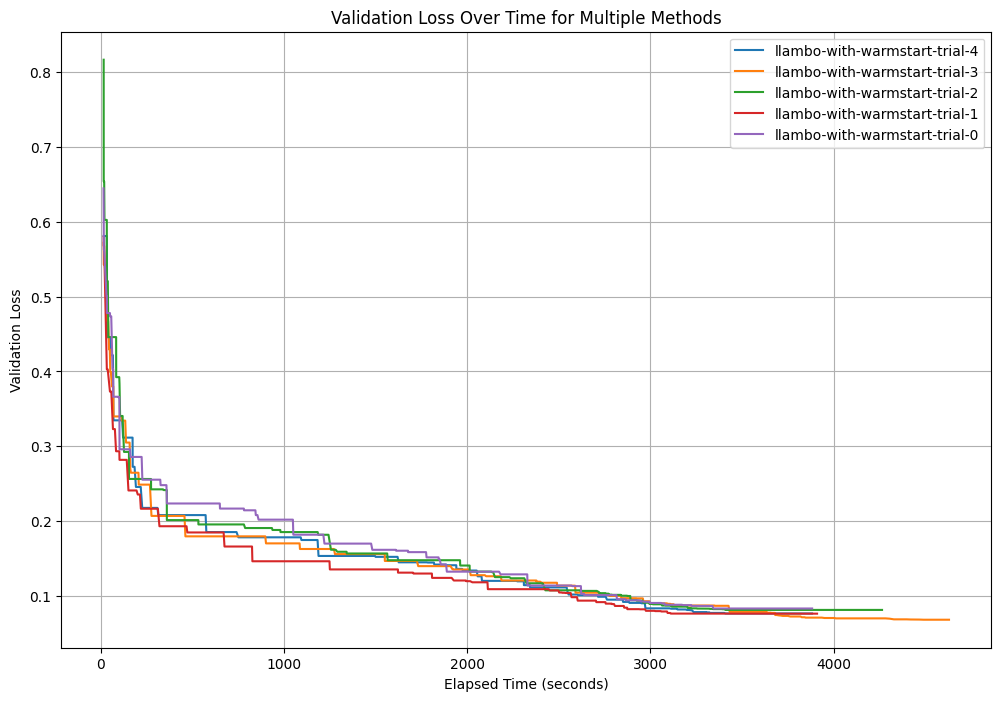

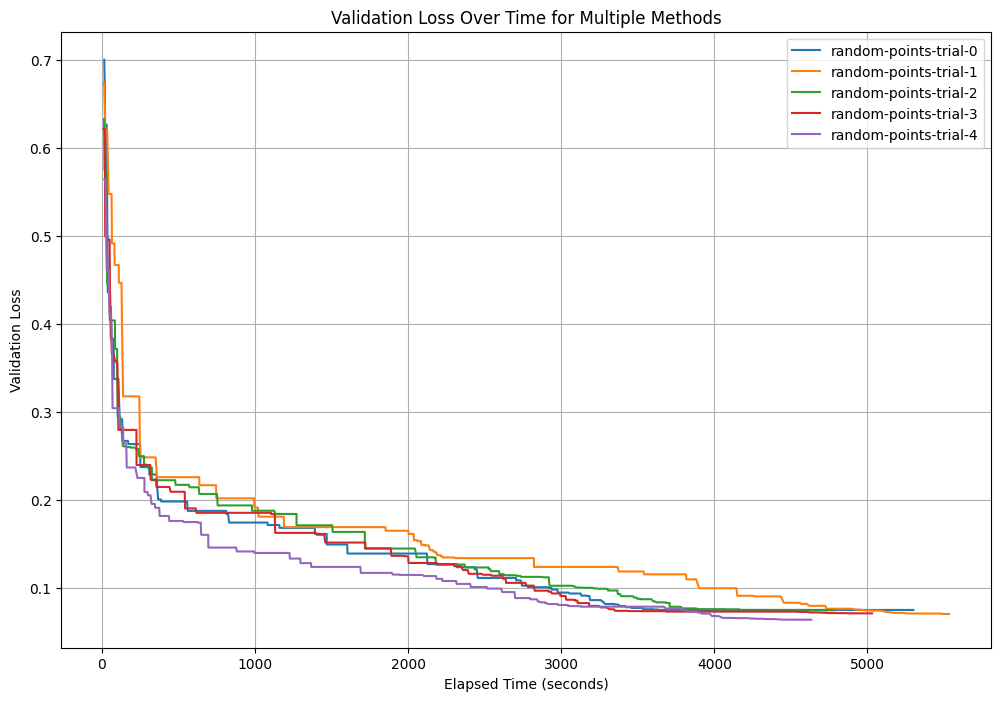

In [19]:
from syne_tune.experiments import load_experiment
import matplotlib.pyplot as plt

experiment_names = [
    "llambo-with-warmstart-trial-4",
    "llambo-with-warmstart-trial-3",
    "llambo-with-warmstart-trial-2",
    "llambo-with-warmstart-trial-1",
    "llambo-with-warmstart-trial-0"
]

random_experiments_names = [
    "random-points-trial-0",
    "random-points-trial-1",
    "random-points-trial-2",
    "random-points-trial-3",
    "random-points-trial-4"
]

experiments = {name: load_experiment(name) for name in experiment_names}
random_experiments = {name: load_experiment(name) for name in random_experiments_names}

plt.figure(figsize=(12, 8))

for name, experiment in experiments.items():
    df = experiment.results
    if df is not None and len(df) > 0:
        metric_name, metric_mode = experiment._metric_name_mode(0)
        df = df.sort_values("metric_elapsed_time")
        x = df["metric_elapsed_time"]
        y = df[metric_name].cummax() if metric_mode == "max" else df[metric_name].cummin()
        plt.plot(x, y, label=name, linestyle='-')

plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Time for Multiple Methods')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
for name, experiment in random_experiments.items():
    df = experiment.results
    if df is not None and len(df) > 0:
        metric_name, metric_mode = experiment._metric_name_mode(0)
        df = df.sort_values("metric_elapsed_time")
        x = df["metric_elapsed_time"]
        y = df[metric_name].cummax() if metric_mode == "max" else df[metric_name].cummin()
        plt.plot(x, y, label=name, linestyle='-')

plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Time for Multiple Methods')
plt.legend()
plt.grid(True)
plt.show()